# Fake News Classification

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from wordcloud import WordCloud

## Introduction
In today's digital age, misinformation and fake news have become major societal concerns. 
The goal of this project is to build a machine learning model that can classify news articles as either 'Fake' or 'Real' 
and analyze key linguistic features that contribute to the classification.

## Research Question
**How effectively can machine learning models classify news articles as fake or real, and what linguistic features contribute most to their predictions?**

## Dataset Description

The dataset used for this project is the **[Fake News Classification Dataset](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification?resource=download)**, which contains over **45,000 unique news articles** in the English language. Each article is labeled as either **true (1)** or **false (0)**, making it a valuable resource for studying fake news detection.

### Dataset Breakdown
- **Training Set**: 24,353 instances used for training the model.
- **Validation Set**: 8,117 instances used to tune hyperparameters and evaluate performance during training.
- **Test Set**: 8,117 instances used to evaluate the final model’s performance.

### Features
- **id**: An integer that uniquely identifies each article.
- **title**: The title or headline of the article.
- **text**: The full content of the article.
- **label**: A binary label indicating whether the article is true (1) or false (0).

In [3]:
# Load all datasets
eval_df = pd.read_csv("evaluation.csv", sep=";", engine="python")
test_df = pd.read_csv("test (1).csv", sep=";", engine="python")
train_df = pd.read_csv("train (2).csv", sep=";", engine="python")

In [4]:
# Check if columns are properly separated
eval_df.head()

,Unnamed: 0,title,text,label
0,0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [5]:
test_df.head()

,Unnamed: 0,title,text,label
0,0,"Live from New York, it's a Trump-Clinton remat...",NEW YORK (Reuters) - Veteran actor and frequen...,1
1,1,Catalan separatists to lose majority in tight ...,BARCELONA (Reuters) - Catalonia s independence...,1
2,2,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. (Reuters) - North Carolina...",1
3,3,Draft Senate Iran legislation sets tough new U...,WASHINGTON (Reuters) - Draft legislation respo...,1
4,4,California governor taps U.S. Representative B...,"SACRAMENTO, Calif. (Reuters) - California Gove...",1


In [6]:
train_df.head()

,Unnamed: 0,title,text,label
0,0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1
1,1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1
2,2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0
3,3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1
4,4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0


## Data Preprocessing

To prepare the text for modeling, the following cleaning operations were applied:

- **Removing Extra Spaces**: Using regex (\s+) to replace multiple consecutive whitespace characters with a single space.
- **Removing Punctuation**: Using regex ([^\w\s]) to eliminate punctuation marks to ensure uniform text formatting.

These steps ensure that the data is clean, standardized, and ready for tokenization and vectorization.

In [7]:
# Cleaning the text
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)
eval_df['text'] = eval_df['text'].apply(clean_text)

# Check cleaned data
print(train_df.head())

   Unnamed: 0                                              title  \
0           0  Palestinians switch off Christmas lights in Be...   
1           1  China says Trump call with Taiwan president wo...   
2           2   FAIL! The Trump Organization’s Credit Score W...   
3           3  Zimbabwe military chief's China trip was norma...   
4           4  THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...   

                                                text  label  
0  RAMALLAH West Bank Reuters  Palestinians switc...      1  
1  BEIJING Reuters  US Presidentelect Donald Trum...      1  
2  While the controversy over Trump s personal ta...      0  
3  BEIJING Reuters  A trip to Beijing last week b...      1  
4  There has never been a more UNCOURAGEOUS perso...      0  


## Data Exploration & Visualization

Understanding the dataset is crucial before modeling. The following visualizations were used:

- **Class Distribution Bar Chart**: Displays the proportion of real vs. fake articles to identify class imbalance.
- **Word Clouds**:
  - *Fake vs. Real News (Text-based)* to analyze word frequency differences.
  - *Fake vs. Real News (Title-based)* to detect clickbait patterns.

In [8]:
print(eval_df.info())
print(test_df.info())
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8117 entries, 0 to 8116
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8117 non-null   int64 
 1   title       8117 non-null   object
 2   text        8117 non-null   object
 3   label       8117 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 253.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   U

In [9]:
# Checking for missing values
print(eval_df.isnull().sum())
print(test_df.isnull().sum())
print(train_df.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64
Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


### Class Distribution Bar Chart

- Shows the proportion of real vs. fake news articles to check for **class imbalance**.
- Helps justify whether additional techniques *(e.g., resampling)* are needed.

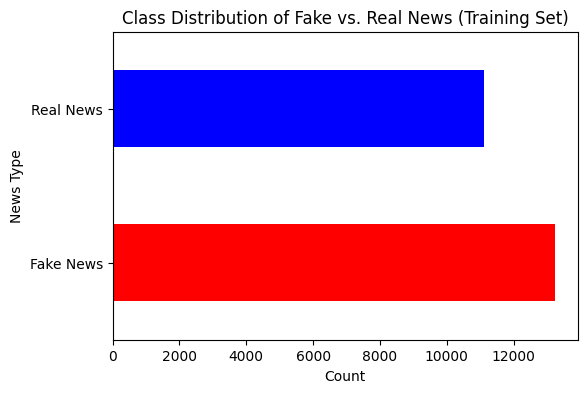

In [10]:
# Assuming 'label' is the target column (1 = Real, 0 = Fake)
class_counts = train_df['label'].value_counts()

# Horizontal Bar Chart
plt.figure(figsize=(6,4))
class_counts.plot(kind='barh', color=['red', 'blue'])
plt.yticks(ticks=[0, 1], labels=['Fake News', 'Real News'])
plt.xlabel('Count')
plt.ylabel('News Type')
plt.title('Class Distribution of Fake vs. Real News (Training Set)')
plt.show()

### Word Cloud - Fake vs Real News (Text-based)

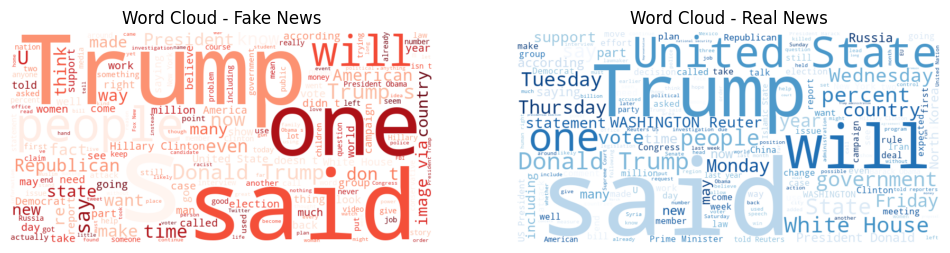

In [11]:
# Separate the articles based on label (0 = Fake, 1 = Real)
fake_news = train_df[train_df['label'] == 0]['text']
real_news = train_df[train_df['label'] == 1]['text']

# Combine the text of fake news and real news into single strings
fake_news_text = ' '.join(fake_news)
real_news_text = ' '.join(real_news)

# Generate Word Cloud for Fake News
fake_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_news_text)

# Generate Word Cloud for Real News
real_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_news_text)

# Plotting both Word Clouds
plt.figure(figsize=(12, 6))

# Plot for Fake News
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for a cleaner look
plt.title('Word Cloud - Fake News')

# Plot for Real News
plt.subplot(1, 2, 2)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News')

# Show the plot
plt.show()

### Word Cloud - Fake vs Real News (Title-based)

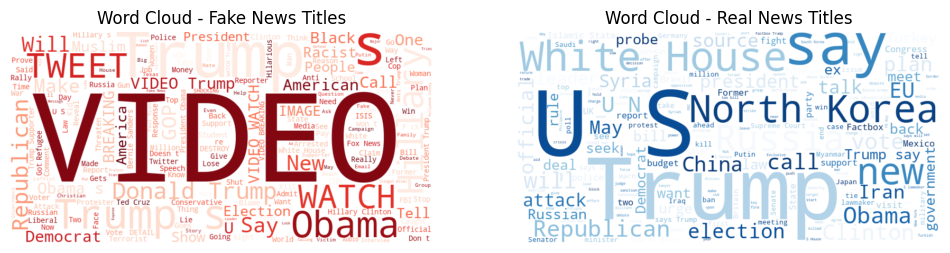

In [12]:
# Separate titles based on label (0 = Fake, 1 = Real)
fake_titles = train_df[train_df['label'] == 0]['title']
real_titles = train_df[train_df['label'] == 1]['title']

# Combine the titles into single strings
fake_titles_text = ' '.join(fake_titles)
real_titles_text = ' '.join(real_titles)

# Generate Word Clouds for Titles
fake_title_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_titles_text)
real_title_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_titles_text)

# Plotting both Title Word Clouds
plt.figure(figsize=(12, 6))

# Plot for Fake News Titles
plt.subplot(1, 2, 1)
plt.imshow(fake_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Fake News Titles')

# Plot for Real News Titles
plt.subplot(1, 2, 2)
plt.imshow(real_title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Real News Titles')

# Show the plots
plt.show()

The **text-based word cloud** reveals key linguistic differences between real and fake news. While both share terms like **“Trump”** and **“said,”** real news emphasizes **institutional and data-driven language** (**“White House,” “percent,” “government”**), whereas fake news relies on **generalized and predictive terms** (**“one,” “people,” “will,” “Republican”**), often contributing to sensationalized narratives.

The **title-based word cloud** highlights how fake news uses **clickbait and emotionally charged terms** (**“Video,” “Watch,” “Image,” “Election”**) and **polarizing political figures** (**“Obama,” “Hillary,” “Trump,” “Muslim”**) to drive engagement. In contrast, real news focuses on **geopolitical and policy-related topics** (**“Russia,” “North Korea,” “Syria,” “law,” “UN”**), reinforcing credibility.

These findings suggest that **fake news headlines prioritize attention-grabbing and emotionally driven content**, while real news emphasizes **factual reporting and authoritative sources**.

## Data Subsampling

To facilitate faster experimentation, a subset of the training data was sampled:

In [13]:
# Sampling 10% of the training data (if you need a smaller subset for faster experimentation)
train_sampled = train_df.sample(frac=0.80, random_state=42)

# Separate the features (X) and labels (y) for both sampled training and full test data
X_train_sampled = train_sampled['text']  # Assuming 'text' column for features
y_train_sampled = train_sampled['label']  # Assuming 'label' column for target
X_test = test_df['text']
y_test = test_df['label']

# If you plan to use evaluation data (eval_df) for validation or additional checks:
X_eval = eval_df['text']
y_eval = eval_df['label']

# Check the size of the sampled training set and test set
print(f"Sampled Training Set Size: {X_train_sampled.shape}")
print(f"Test Set Size: {X_test.shape}")
print(f"Evaluation Set Size: {X_eval.shape}")

Sampled Training Set Size: (19482,)
Test Set Size: (8117,)
Evaluation Set Size: (8117,)


## Modeling

### Baseline Model: Naive Bayes
- Used as a baseline for classification.
- **Feature importance visualization** included.

In [14]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')  # Adjust max_features if needed

X_train = vectorizer.fit_transform(X_train_sampled)  # Fit and transform 
X_test = vectorizer.transform(X_test)  # Transform test data
X_eval_vectorized = vectorizer.transform(X_eval) # Transform evaluation data

In [15]:
# Initialize model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train_sampled)

MultinomialNB()

In [16]:
# Predict on test set
nb_predictions = nb_model.predict(X_test)

In [17]:
# Evaluate performance
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naïve Bayes Accuracy: {nb_accuracy:.4f}")

Naïve Bayes Accuracy: 0.9284


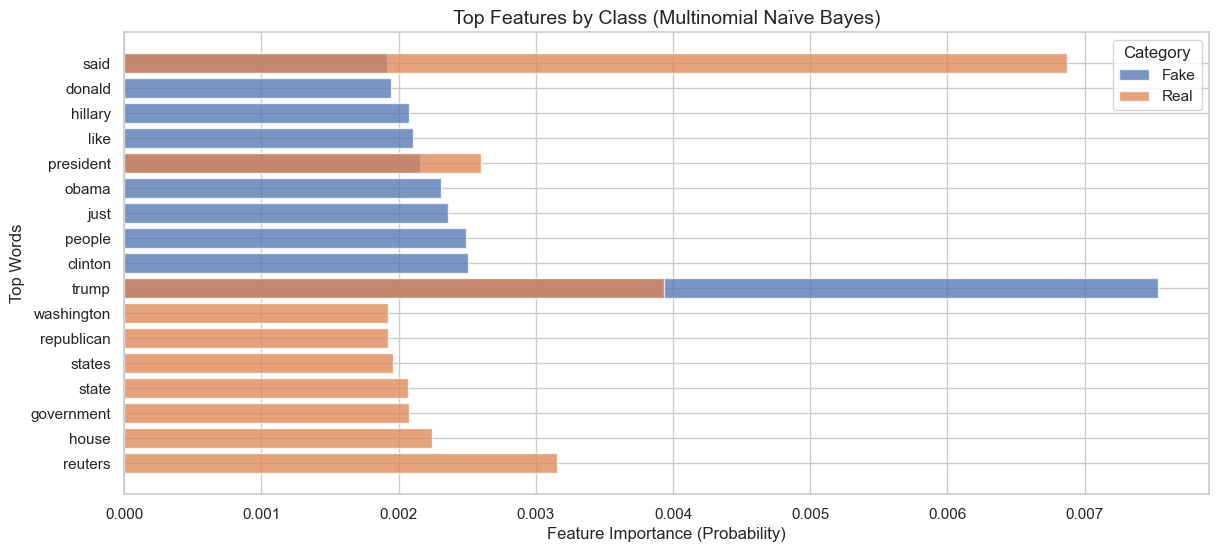

In [18]:
# Set Seaborn style
sns.set_theme(style="whitegrid")

# Get feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get class-wise feature importance (log probabilities)
class_labels = ["Fake", "Real"]  # Mapping numerical classes to meaningful labels
top_n = 10  # Show top 10 words per class

plt.figure(figsize=(14, 6))

for i, label in enumerate(class_labels):
    top_features = np.argsort(nb_model.feature_log_prob_[i])[-top_n:]  # Get top words
    feature_importance = np.exp(nb_model.feature_log_prob_[i, top_features])  # Convert log probs to positive values
    
    plt.barh([feature_names[j] for j in top_features], feature_importance, alpha=0.75, label=label)

plt.xlabel("Feature Importance (Probability)", fontsize=12)
plt.ylabel("Top Words", fontsize=12)
plt.title("Top Features by Class (Multinomial Naïve Bayes)", fontsize=14)
plt.legend(title="Category")  # Adding a title to the legend
plt.gca().invert_yaxis()  # Keep most important words at the top
plt.show()

### SVC Model (for comparison)

- Effectiveness with high-dimensional text data.
- Evaluated using:
  - **Confusion Matrix**
  - **Precision-Recall Curve**

In [19]:
# Train the SVC model
model_svc = SVC(kernel='linear', probability=True)  # Linear kernel for text classification
model_svc.fit(X_train, y_train_sampled)  # Train the model

SVC(kernel='linear', probability=True)

In [20]:
# Evaluate model
print(f"SVC Model Accuracy: {model_svc.score(X_test, y_test)}")

SVC Model Accuracy: 0.9795490944930393


In [22]:
# Make predictions on the test data
predictions = model_svc.predict(X_test)

In [26]:
# Evaluate the model
class_report = classification_report(y_test, predictions)

In [27]:
# Print results
print(f"Classification Report:\n{class_report}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3753
           1       0.99      0.98      0.98      4364

    accuracy                           0.98      8117
   macro avg       0.98      0.98      0.98      8117
weighted avg       0.98      0.98      0.98      8117



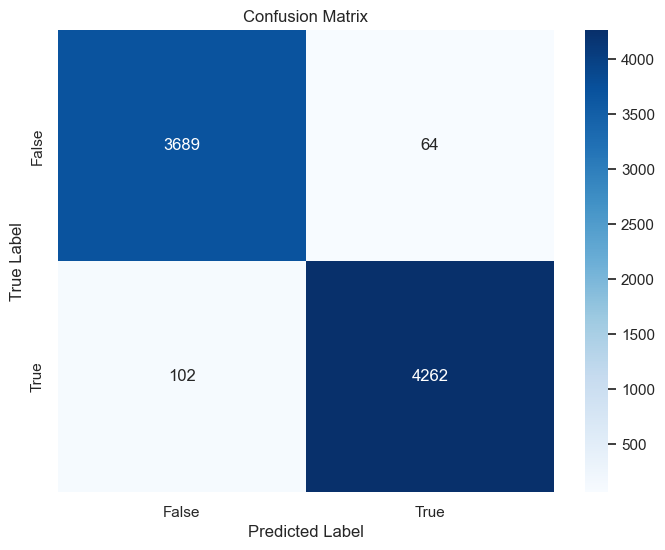

Confusion Matrix Summary:
True Negatives: 3689
False Positives: 64
False Negatives: 102
True Positives: 4262


In [28]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix summary
tn, fp, fn, tp = conf_matrix.ravel()

print(f"Confusion Matrix Summary:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

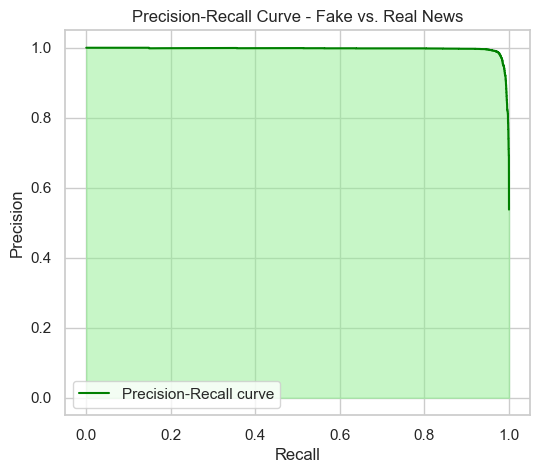

In [30]:
# Get the predicted probabilities for the positive class (real news in this case)
y_prob = model_svc.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (real news)

# Calculate precision and recall values at different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.fill_between(recall, precision, color='lightgreen', alpha=0.5)  # Area under curve
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Fake vs. Real News')
plt.legend(loc='lower left')
plt.show()

## Evaluation

To assess the effectiveness of our models in classifying news articles as real or fake, we used multiple evaluation metrics, including accuracy, precision, recall, and F1-score. These metrics provide a comprehensive understanding of each model’s ability to distinguish between real and fake news. Additionally, we employed visualizations such as feature importance analysis, a confusion matrix, and a precision-recall curve to further interpret model performance.

### Naïve Bayes Model Evaluation
The **Naïve Bayes classifier** achieved an accuracy of **92.84%**, indicating a strong baseline performance.

**Key Observations from Feature Importance**
- Words such as **“donald,” “hillary,” “obama,” “clinton,” “just,” and “people”** were strongly associated with ***fake news***, suggesting that political names and common conversational words frequently appear in misleading articles.
- Words such as **“said,” “president,” “trump,” “washington,” “republican,” “states,” “government,” and “reuters”** were key indicators of ***real news***, highlighting the presence of structured reporting, named entities, and credible news sources.
- The dominance of the word **“said”** suggests that real news sources frequently include quotations, reinforcing credibility.

The **feature importance visualization (horizontal bar graph)** further illustrates the most influential words in classification.

### SVC Model Evaluation
The **Support Vector Classifier (SVC)** outperformed Naïve Bayes, achieving an accuracy of **97.95%**.

**Classification Report**
| Class | Precision | Recall | F1-Score | Support |
| ----- | --------- | ------ | -------- | ------- |
| Fake News (0) | 0.97 | 0.98 | 0.98 | 3752 |
| Real News (1) | 0.99 | 0.98 | 0.98 | 4364 |
| Overall Accuracy | 0.98 | 0.98 | 0.98 | 8117 |
- The **confusion matrix** shows that the SVC model makes fewer misclassifications compared to Naïve Bayes.
- The **precision-recall curve** highlights the model's effectiveness in distinguishing between real and fake news, maintaining high precision and recall across both classes.

### Model Comparison & Insights
- **Naïve Bayes**, despite its simpler assumptions, performed well with **92.84% accuracy** and provided insightful feature importance rankings. However, it might struggle with more complex relationships in the text data.
- **SVC**, leveraging its ability to find optimal decision boundaries, achieved a higher accuracy of **97.95%**, suggesting better generalization.
- **Interpretability vs. Accuracy**: While Naïve Bayes provides interpretable word associations, SVC offers superior performance at the cost of reduced transparency.

Given these results, **SVC is the preferred model for fake news detection**, as it acheives near-optimal classification accuracy while maintaining strong precision and recall.

## Storytelling
The contrast between fake and real news is not just in content but in the way information is framed. **Fake news headlines** use **emotionally charged and sensational words**, such as “Watch,” “Video,” “Obama,” and “Hillary,” designed to **evoke strong reactions and drive engagement**. In contrast, **real news headlines** emphasize **institutional credibility and geopolitical events**, using words like “White House,” “Government,” “Source,” and “Law.”

The **Naïve Bayes model’s feature analysis** further reveals how fake news often generalizes, using words like **“people” and “Republican,”** while real news relies on **quoted sources (“said”) and official entities (“Reuters”)**. This distinction aligns with the broader pattern of misinformation, which thrives on **clickbait strategies and political polarization**, whereas legitimate news emphasizes **verification and source attribution**.

Through these linguistic patterns, we see how misinformation **crafts narratives that resonate emotionally, while real news builds trust through structured reporting**.

## Impact
The **high accuracy** of the **SVC model (97.95%)** and **Naïve Bayes model (92.84%)** demonstrates that **misinformation follows predictable patterns**, making it identifiable with machine learning. However, the **confusion matrix and precision-recall curve** reveal that some fake news articles closely mimic real ones, highlighting the challenge of distinguishing them based solely on text.

The ability to classify fake news accurately is **crucial in an era of rapid information spread**. Understanding the linguistic features of misinformation **empowers readers to critically assess online content**. Additionally, the reliance of fake news on **emotionally provocative language** suggests that addressing misinformation requires **not just better detection, but also public awareness and media literacy initiatives**.

By leveraging **automated detection alongside human critical thinking**, we can help curb the spread of misinformation and promote a more informed society.

## References
- Kaggle Dataset: [Fake News Classification](https://www.kaggle.com/datasets/aadyasingh55/fake-news-classification)